## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import calib_utils
from utils import post_utils
from utils import config_utils
from utils import eval_utils
from utils import model_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [40]:
iso_code = "AF"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AF.yaml")
config_file = os.path.join(os.getcwd(), "configs/best_models.yaml")
data_config = config_utils.load_config(data_config_file)
config = config_utils.create_config(config_file)

## Load Validation Results

In [41]:
val_output = model_utils.ensemble_models(iso_code, config, phase="val")
test_output = model_utils.ensemble_models(iso_code, config, phase="test")
print(test_output.shape)
test_output.head(3)

(10976, 20)


,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,validated_x,validated_y,y_true,y_preds,y_probs
0,UNICEF-BEN-SCHOOL-00000042,UNICEF,BEN,Benin,Africa,Sub-Saharan Africa,NaN,42,0,0.0,school,13,rural,test,POINT (212257.24947241327 921729.4117069786),NaN,NaN,1,1,0.954234
1,UNICEF-BEN-SCHOOL-00000044,UNICEF,BEN,Benin,Africa,Sub-Saharan Africa,NaN,44,0,0.0,school,12,rural,test,POINT (102457.09995953638 1270201.0789103),NaN,NaN,1,1,0.963906
2,UNICEF-BEN-SCHOOL-00000049,UNICEF,BEN,Benin,Africa,Sub-Saharan Africa,NaN,49,0,0.0,school,12,rural,test,POINT (165572.35879668887 1267371.8041139916),NaN,NaN,1,1,0.953684


## Load Evaluation

In [42]:
val_results = eval_utils.evaluate(
    y_true=val_output["y_true"], 
    y_pred=val_output["y_preds"], 
    y_prob=val_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=1
)
test_results = eval_utils.evaluate(
    y_true=test_output["y_true"], 
    y_pred=test_output["y_preds"], 
    y_prob=test_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=1,
    optim_threshold=val_results["optim_threshold"]
)
test_results

{'auprc': 0.9840082448249253,
 'ap': 0.9840082448249253,
 'roc_auc': 0.9910365109843396,
 'brier_score': 0.03671234263664824,
 'precision_scores_': array([0.33928571, 0.33931663, 0.33934755, ..., 1.        , 1.        ,
        1.        ]),
 'recall_scores_': array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        5.37056928e-04, 2.68528464e-04, 0.00000000e+00]),
 'thresholds_': array([0.04527209, 0.04611682, 0.04631152, ..., 0.96759715, 0.9684817 ,
        0.96898731]),
 'optim_threshold': 0.6060754756132761,
 'fbeta_score': 94.58681649993147,
 'precision_score': 96.58550237895327,
 'recall_score': 92.66917293233082,
 'overall_accuracy': 96.40123906705539,
 'balanced_accuracy': 95.4934391964467}

In [43]:
test_output_sub = test_output[test_output["iso"] == "ZWE"]
test_results = eval_utils.evaluate(
    y_true=test_output_sub["y_true"], 
    y_pred=test_output_sub["y_preds"], 
    y_prob=test_output_sub["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2,
    optim_threshold=val_results["optim_threshold"]
)
test_results

{'auprc': 0.9931281956403224,
 'ap': 0.9931281956403224,
 'roc_auc': 0.9966697382672939,
 'brier_score': 0.031659480039514146,
 'precision_scores_': array([0.33531409, 0.33559898, 0.33588435, ..., 1.        , 1.        ,
        1.        ]),
 'recall_scores_': array([1.        , 1.        , 1.        , ..., 0.00506329, 0.00253165,
        0.        ]),
 'thresholds_': array([0.04631152, 0.050191  , 0.05019632, ..., 0.9628817 , 0.96293869,
        0.96325119]),
 'optim_threshold': 0.6060754756132761,
 'fbeta_score': 95.11698880976603,
 'precision_score': 96.89119170984456,
 'recall_score': 94.68354430379748,
 'overall_accuracy': 97.19864176570458,
 'balanced_accuracy': 96.57548862699453}

## Plot Results

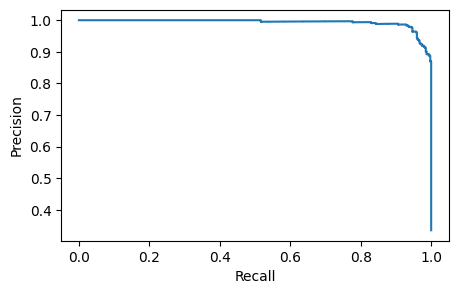

In [44]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

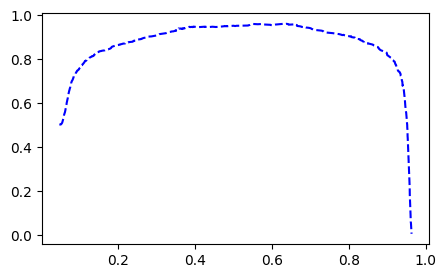

In [45]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['thresholds_'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_fscores[:-1], "b--");

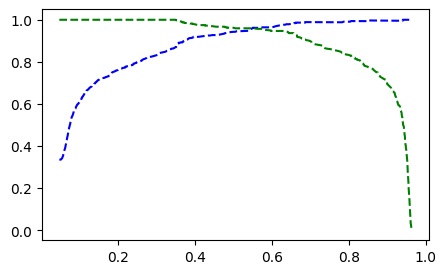

In [46]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_results['precision_scores_'][:-1], "b--")
ax.plot(test_results['thresholds_'], test_results['recall_scores_'][:-1], "g--");